In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import importlib
import tqdm
from tqdm import tqdm
import matplotlib.colors as mcolors
from copy import deepcopy
from gudhi.representations import Landscape, PersistenceImage

import topofisher 
from topofisher.input_simulators.noisy_ring import CircleSimulator

from topofisher.filtrations.numpy.alphaDTML import AlphaDTMLayer
from topofisher.filtrations.tensorflow.dtm_layer import DTMFiltLayer, NNFiltLayer
from topofisher.filtrations.tensorflow.filt_utils import ExtraDimFiltLayer
from topofisher.filtrations.visualization import visualizeFiltrations

from topofisher.vectorizations.numpy.custom_vectorizations import TOPK
from topofisher.vectorizations.numpy.vectorization_layer import VectorizationLayers
from topofisher.vectorizations.numpy.shorthand_layers import PersistenceImages, PersistenceLandscapes

from topofisher.vectorizations.tensorflow.custom_vectorizations import TOPK_TF
from topofisher.vectorizations.tensorflow.vectorization_layer import VectorizationLayers_TF

from topofisher.fisher.Fisher import show_fm_and_bias, fisherFromVecs
from topofisher.fisher.imnn import IMNNLayer, MopedLayer, ExtraDimLayer, plot_loss
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence


from topofisher.pipelines.circle import CirclePipeline
from topofisher.pipelines.convergence_checks import fisher_estimates_wrt_step_size
from topofisher.pipelines.utils import readFromFile, writeToFile

import gudhi.representations as gdr
import gudhi.tensorflow.perslay as prsl
from gudhi.point_cloud.knn import KNearestNeighbors
from topofisher.input_simulators.noisy_ring import CircleSimulator
import gudhi

2023-10-05 16:50:40.993256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 16:50:49.243962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading the data and comparing the full derivatives

In [4]:
#pi_vec_layer = circle_pipeline.vecLayer
"""

all_vecs = []
for pds in circle_pipeline.all_persistence_diagrams:
    vecs = pi_vec_layer.vectorize_persistence_diagrams(pds)
    all_vecs.append(vecs)
"""
res = 24
circle_pipeline = readFromFile("pipeline_m_p9_ns_10K_dtheta_p01.pkl")
all_vecs = circle_pipeline.all_vecs
pi_vec_layer = PersistenceImages(resolutions = [[res, res], [res, res]], bandwidths = [3e-2, 5e-2])
for idx, vectorizations in enumerate(pi_vec_layer.vectorizations): 
    vectorizations.fit(circle_pipeline.all_persistence_diagrams[0][idx])


### Perslay = PI?

In [5]:
# Setting up perslay layer
extents = [item.im_range_fixed_.reshape((2,2)) for item in pi_vec_layer.vectorizations]
rho = tf.identity
phis = [prsl.GaussianPerslayPhi((res, res), extents[0], 3e-2), \
        prsl.GaussianPerslayPhi((res, res), extents[1], 5e-2)]
weights = [prsl.PowerPerslayWeight(1., 2), prsl.PowerPerslayWeight(1., 2)]
perm_op = tf.math.reduce_sum
perslays = [prsl.Perslay(phi=phis[0], weight=weights[0], perm_op=perm_op, rho=rho),\
            prsl.Perslay(phi=phis[1], weight=weights[1], perm_op=perm_op, rho=rho)]


#### Test run

In [28]:
filtLayer = DTMFiltLayer(max_hom_dim = 2, complex_args = {'complex_type':"alpha"}, is_ragged = True, num_nn = 198, \
                             data_format = 'hom_dim_first')
theta_fid = tf.constant([1., 0.2])
noisy_ring =  CircleSimulator(200, 20, 1.)
all_pts = noisy_ring.generateInstances(theta_fid, num_sims, seed = circle_pipeline.seed_cov)
y = filtLayer(all_pts)
vecs = tf.concat([perslays[0](y[0]), perslays[1](y[1])], axis = -1)

In [38]:
print("Is Perslay = PI?")
ind = np.random.randint(10)
print(np.max(vecs[ind,:,:,1].numpy()), np.mean(vecs[ind,:,:,1].numpy()))
print(np.max(all_vecs[0][ind, :, :, 1]), np.mean(all_vecs[0][ ind, :, :, 1]))

Is Perslay = PI?
5.7091856 0.15412219
5.709185733176307 0.1541221082016259


### Plotting average derivative

In [71]:
def test_run(num_sims):
    filtLayer = DTMFiltLayer(max_hom_dim = 2, complex_args = {'complex_type':"alpha"}, is_ragged = True, num_nn = 198, \
                             data_format = 'hom_dim_first')
    theta_fid = tf.constant([1., 0.2])
    A = tf.eye(2)
    sims = []
    derivs = []
    for item in A:
        with tf.autodiff.ForwardAccumulator(theta_fid , tf.constant(item)) as acc:
            noisy_ring =  CircleSimulator(200, 20, 1.)
            all_pts = noisy_ring.generateInstances(theta_fid, num_sims, seed = circle_pipeline.seed_cov)
            y = filtLayer(all_pts)
            vecs = [[],[]]
            for hom_dim in [0,1]:
                for diags in y[hom_dim]:
                    
                    op = perslays[hom_dim](tf.expand_dims(diags, 0))
                    vecs[hom_dim].append(tf.squeeze(op, [0, -1]))
            
            
        sims.append(vecs)
        derivs.append(acc.jvp(vecs))
    # return tf.stack(sims), tf.stack(derivs)
    return tf.stack(sims), tf.stack(derivs)

num_sims = 1000
sims, derivs = test_run(num_sims)

In [72]:
sims.shape, derivs.shape

(TensorShape([2, 2, 1000, 24, 24]), TensorShape([2, 2, 1000, 24, 24]))

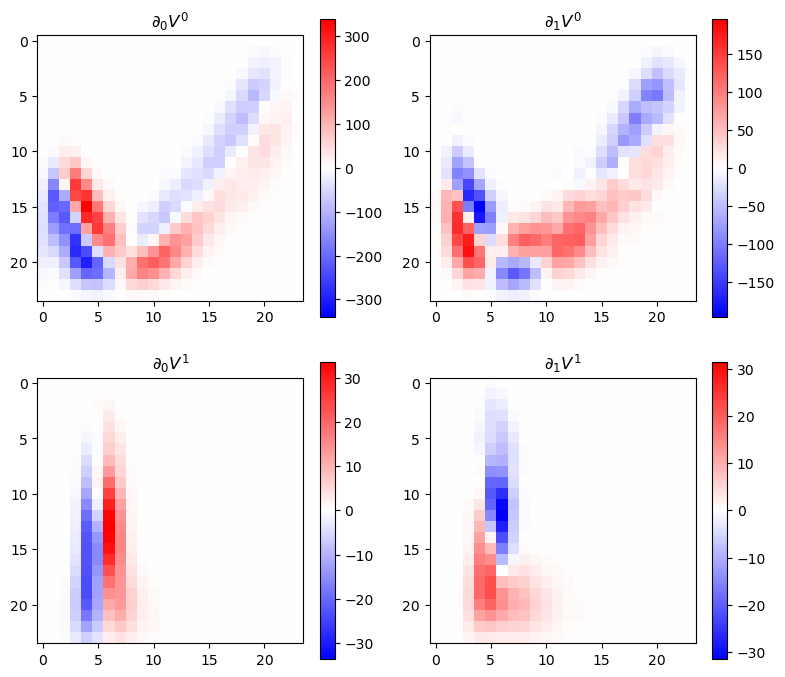

In [73]:
ncols = 2; nrows = 2;
ind = np.random.randint(num_sims)
fig, axes = plt.subplots(nrows = 2, ncols= ncols, figsize=(3 * ncols + 2 , 3 * nrows + 1))
vmax = [400, 50]

for hom_dim in range(2):
    for theta_dim in range(2):
        ax = axes[hom_dim][theta_dim]
        ax.set_title("$\partial_" + str(theta_dim) + "V^" + str(hom_dim) + "$")
        arr = tf.math.reduce_mean(derivs[theta_dim, hom_dim, :, :, :], axis = 0)
        vmax = np.max(np.abs(arr))
        # im = ax.imshow(np.flip(arr.numpy(), 0),  cmap = 'bwr')
        im = ax.imshow(np.flip(arr.numpy(), 0), vmax = vmax, vmin = -vmax, cmap = 'bwr')
        cbar = ax.figure.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

### Difference between numerical derivative and auto derivative

In [137]:
def test_run(num_sims):
    filtLayer = DTMFiltLayer(max_hom_dim = 2, complex_args = {'complex_type':"alpha"}, is_ragged = True, num_nn = 198, \
                             data_format = 'hom_dim_first')
    theta_fid = tf.constant([1., 0.2])
    A = tf.eye(2)
    sims = []
    derivs = []
    for idx, item in enumerate(A):
        with tf.autodiff.ForwardAccumulator(theta_fid , tf.constant(item)) as acc:
            noisy_ring =  CircleSimulator(200, 20, 1.)
            all_pts = noisy_ring.generateInstances(theta_fid, num_sims, seed = circle_pipeline.seed_ders[idx])
            #plt.scatter(all_pts[0, :10, 0], all_pts[0, :10, 1])
            # plt.scatter(circle_pipeline.all_pts[2*idx + 1][0, :10, 0], circle_pipeline.all_pts[2*idx + 1][0, :10, 1])
            
            #plt.scatter(circle_pipeline.all_pts[2*idx + 2][0, :10, 0], circle_pipeline.all_pts[2*idx + 2][0, :10, 1], alpha = 0.5)
            #plt.show()
            y = filtLayer(all_pts)
            vecs = [[],[]]
            for hom_dim in [0,1]:
                for diags in y[hom_dim]:
                    
                    op = perslays[hom_dim](tf.expand_dims(diags, 0))
                    vecs[hom_dim].append(tf.squeeze(op, [0, -1]))
            
            
        sims.append(vecs)
        derivs.append(acc.jvp(vecs))
    # return tf.stack(sims), tf.stack(derivs)
    return tf.stack(sims), tf.stack(derivs)

num_sims = 100
sims, derivs = test_run(num_sims)

In [138]:
delta_theta = circle_pipeline.delta_theta
der_vecs = tf.stack(all_vecs[1:])
delta_theta_cast = tf.cast(delta_theta[:, tf.newaxis, tf.newaxis, tf.newaxis, tf.newaxis], \
                               der_vecs.dtype)
numerical_derivatives = (der_vecs[1::2] - der_vecs[::2])/delta_theta_cast
numerical_derivatives = tf.einsum("i...j->ij...", numerical_derivatives)

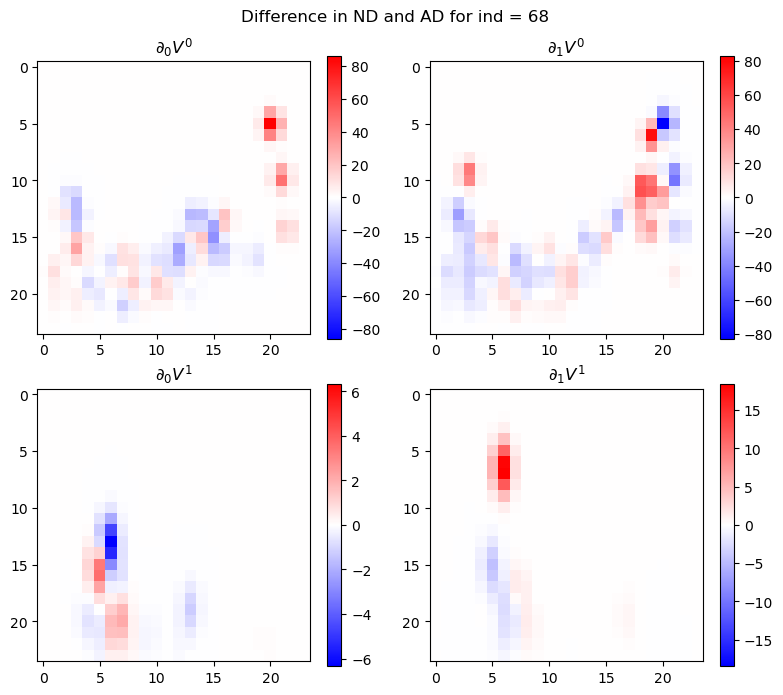

In [139]:
ncols = 2; nrows = 2;
ind = np.random.randint(num_sims)
fig, axes = plt.subplots(nrows = 2, ncols= ncols, figsize=(3 * ncols + 2 , 3 * nrows + 1))
vmax = [400, 50]
ind = np.random.randint(num_sims)
for hom_dim in range(2):
    for theta_dim in range(2):
        ax = axes[hom_dim][theta_dim]
        ax.set_title("$\partial_" + str(theta_dim) + "V^" + str(hom_dim) + "$")
        arr = sims[theta_dim, hom_dim, ind, :, :] -  \
            tf.cast(all_vecs[theta_dim][ind, :, :, hom_dim], sims.dtype)
        vmax = np.max(np.abs(arr))
        # im = ax.imshow(np.flip(arr.numpy(), 0),  cmap = 'bwr')
        im = ax.imshow(np.flip(arr.numpy(), 0), vmax = vmax, vmin = -vmax, cmap = 'bwr')
        cbar = ax.figure.colorbar(im, ax=ax)

fig.suptitle("Difference in ND and AD for ind = " + str(ind))
plt.tight_layout()
plt.show()

In [ ]:
ncols = 2; nrows = 2;
ind = np.random.randint(num_sims)
fig, axes = plt.subplots(nrows = 2, ncols= ncols, figsize=(3 * ncols + 2 , 3 * nrows + 1))
vmax = [400, 50]

for hom_dim in range(2):
    for theta_dim in range(2):
        ax = axes[hom_dim][theta_dim]
        ax.set_title("$\partial_" + str(theta_dim) + "V^" + str(hom_dim) + "$")
        arr = tf.math.reduce_mean(derivs[theta_dim, hom_dim, :, :, :], axis = 0) - \
                tf.cast(tf.math.reduce_mean(numerical_derivatives[theta_dim, hom_dim, :num_sims, :, :], axis = 0), derivs.dtype)
        vmax = np.max(np.abs(arr))
        # im = ax.imshow(np.flip(arr.numpy(), 0),  cmap = 'bwr')
        im = ax.imshow(np.flip(arr.numpy(), 0), vmax = vmax, vmin = -vmax, cmap = 'bwr')
        cbar = ax.figure.colorbar(im, ax=ax)
fig.suptitle("Mean Difference in ND and AD for num_sims = " + str(num_sims))
plt.tight_layout()
plt.show()

## Comparing compressed derivative - AD and ND

### Training IMNN

In [366]:
import topofisher
importlib.reload(topofisher)
importlib.reload(topofisher.fisher.Fisher)
importlib.reload(topofisher.fisher.imnn)
importlib.reload(topofisher.filtrations.tensorflow.flag_layer)
importlib.reload(topofisher.filtrations.tensorflow.dtm_layer)
from topofisher.filtrations.tensorflow.dtm_layer import DTMFiltLayer, NNFiltLayer
from topofisher.fisher.Fisher import show_fm_and_bias, fisherMOPED, fisherFromVecs
from topofisher.fisher.imnn import IMNNLayer, MopedLayer, ExtraDimLayer, plot_loss, FisherLayer
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence

In [ ]:
conv1 = tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 2))
mp1 = tf.keras.layers.MaxPooling2D((2, 2), strides=2)
dense1 = tf.keras.layers.Dense(12, activation="relu")
dense2 = tf.keras.layers.Dense(2)
model = tf.keras.Sequential(
    [
        ExtraDimLayer(conv1),
        ExtraDimLayer(mp1),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        dense1,
        dense2
    ]
)

pi_imnn_layer = IMNNLayer(model, verbose = 1, epochs = 15, data_splits = [0.4, 0.2, 0.4], \
                           callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)], show_bias = True)

fisher = pi_imnn_layer.computeFisher(all_vecs, circle_pipeline.delta_theta)

In [318]:
show_fm_and_bias(fisher)

FM =  [3585.43  177.9   177.9  4190.5 ]
Fractional bias =  [0.19 0.26]


In [386]:
new_model = tf.keras.Sequential(
    [
        conv1,
        mp1,
        tf.keras.layers.Flatten(),
        dense1,
        dense2
    ]
)
def test_run(num_sims):
    filtLayer = DTMFiltLayer(max_hom_dim = 2, complex_args = {'complex_type':"alpha"}, is_ragged = False, num_nn = 198, \
                             data_format = 'hom_dim_first', batched_gather = True)
    theta_fid = tf.constant([1., 0.2])
    A = tf.eye(2)
    sims = []
    derivs = []
    for idx, item in enumerate(A):
        with tf.autodiff.ForwardAccumulator(theta_fid , tf.constant(item)) as acc:
            noisy_ring =  CircleSimulator(200, 20, 1.)
            all_pts = noisy_ring.generateInstances(theta_fid, num_sims, seed = circle_pipeline.seed_ders[idx])
            #plt.scatter(all_pts[0, :10, 0], all_pts[0, :10, 1])
            # plt.scatter(circle_pipeline.all_pts[2*idx + 1][0, :10, 0], circle_pipeline.all_pts[2*idx + 1][0, :10, 1])
            
            #plt.scatter(circle_pipeline.all_pts[2*idx + 2][0, :10, 0], circle_pipeline.all_pts[2*idx + 2][0, :10, 1], alpha = 0.5)
            #plt.show()
            y = filtLayer(all_pts)
            op0 = perslays[0](y[0]); op1 = perslays[1](y[1])
            op = [op0, op1]
        sims.append(op)
        derivs.append(acc.jvp(op))
    return tf.stack(sims), derivs
    # return tf.stack(sims)
num_sims = 10
sims, derivs = test_run(num_sims)

2023-10-09 00:08:26.693406: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedGather_1/RowPartitionFromUniformRowLength_4/assert_equal_1/Assert/AssertGuard/branch_executed/_341
2023-10-09 00:08:27.140351: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedFromRowLengths/RowPartitionFromRowLengths/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_221
2023-10-09 00:08:29.641389: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedGather/RowPartitionFromRowSplits/assert_equal_1/Assert/AssertGuard/branch_executed/_250
2023-10-09 00:08:30.068567: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input:

In [391]:
derivs[0][0].values.numpy().shape

(2190, 24, 24, 1)

### Getting the AD derivative

In [371]:
new_model = tf.keras.Sequential(
    [
        conv1,
        mp1,
        tf.keras.layers.Flatten(),
        dense1,
        dense2
    ]
)
def test_run(num_sims):
    filtLayer = DTMFiltLayer(max_hom_dim = 2, complex_args = {'complex_type':"alpha"}, is_ragged = True, num_nn = 198, \
                             data_format = 'hom_dim_first')
    theta_fid = tf.constant([1., 0.2])
    A = tf.eye(2)
    sims = []
    derivs = []
    for idx, item in enumerate(A):
        with tf.autodiff.ForwardAccumulator(theta_fid , tf.constant(item)) as acc:
            noisy_ring =  CircleSimulator(200, 20, 1.)
            all_pts = noisy_ring.generateInstances(theta_fid, num_sims, seed = circle_pipeline.seed_ders[idx])
            #plt.scatter(all_pts[0, :10, 0], all_pts[0, :10, 1])
            # plt.scatter(circle_pipeline.all_pts[2*idx + 1][0, :10, 0], circle_pipeline.all_pts[2*idx + 1][0, :10, 1])
            
            #plt.scatter(circle_pipeline.all_pts[2*idx + 2][0, :10, 0], circle_pipeline.all_pts[2*idx + 2][0, :10, 1], alpha = 0.5)
            #plt.show()
            y = filtLayer(all_pts)
            # vecs = [perslays[idx](y[idx]) for idx in range(2)]
            vecs = [[],[]]
            for hom_dim in [0,1]:
                for diags in y[hom_dim]:
                    op = perslays[hom_dim](tf.expand_dims(diags, 0))
                    vecs[hom_dim].append(tf.squeeze(op, [0, -1]))
                vecs[hom_dim] = tf.stack(vecs[hom_dim])
            # print([item.shape for item in vecs])
            # vecs_stack = tf.concat(vecs, -1)
            op = vecs
            # op = new_model(vecs_stack)
        sims.append(op)
        derivs.append(acc.jvp(op))
    return tf.stack(sims), tf.stack(derivs)
    # return tf.stack(sims)

In [373]:
num_sims = 100
%timeit -n 1 -r 1 sims, derivs = test_run(num_sims)

2023-10-08 23:36:17.378467: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedGather_1/RowPartitionFromRowSplits/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_409
2023-10-08 23:36:19.563153: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedGather_1/RowPartitionFromUniformRowLength_4/assert_equal_1/Assert/AssertGuard/branch_executed/_431
2023-10-08 23:36:31.313019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedGather_1/RowPartitionFromRowSplits/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_409
2023-10-08 23:36:33.673040: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node w

29.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [360]:
derivs_mean, tf.transpose(jacobian)

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-349.47964, -188.43465],
        [ 275.04184,   77.96884]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-394.04706 , -203.2938  ],
        [ 255.56152 ,   53.211506]], dtype=float32)>)

In [354]:
num_sims = 100
sims, derivs = test_run(num_sims)
derivs_mean = tf.math.reduce_mean(derivs, axis = 1)

2023-10-08 17:41:31.617409: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedGather/RowPartitionFromRowLengths/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_330
2023-10-08 17:41:32.170747: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedGather_1/RowPartitionFromUniformRowLength_4/assert_equal_1/Assert/AssertGuard/branch_executed/_431
2023-10-08 17:41:43.985259: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedGather_1/RowPartitionFromRowSplits/assert_equal_1/Assert/AssertGuard/branch_executed/_400
2023-10-08 17:41:44.527995: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: State

In [128]:
fisher_ad = topofisher.fisher.Fisher.baseFisher(tf.einsum("ij...->ji...", compressed_vecs)[0][-4000:, :], \
                                                derivs[:, -4000:, :])

In [129]:
show_fm_and_bias(fisher_ad)

FM =  [3181.65   50.55   50.55 3886.95]
Fractional bias =  [0.25 0.2 ]


In [108]:
all_vecs = tf.stack(all_vecs)

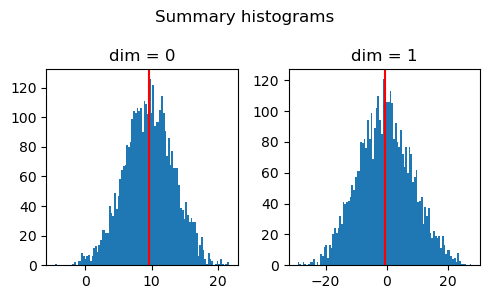

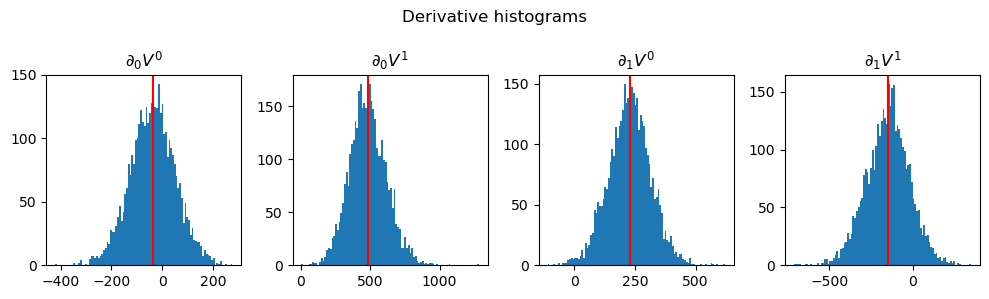

In [131]:
fisher_ad.summaries = [fisher_ad.vecs_cov]
plotSummaryDerivativeHists(fisher_ad)

In [138]:
compressed_vecs = model(tf.einsum("ij...->ji...", all_vecs))[-4000:]
fisher_old = fisherFromVecs(tf.einsum("ij...->ji...", compressed_vecs), circle_pipeline.delta_theta)
show_fm_and_bias(fisher_old)

FM =  [3180.84   58.31   58.31 3958.88]
Fractional bias =  [0.22 0.21]


In [136]:
tf.math.reduce_mean(tf.math.abs((derivs - fisher_old.derivatives[:, :num_sims, :])/derivs), axis = 1)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.221967  , 0.06025622],
       [0.09800047, 0.57254094]], dtype=float32)>

### Trying back propagation

In [347]:
importlib.reload(topofisher.filtrations.tensorflow.flag_layer)
importlib.reload(topofisher.filtrations.tensorflow.dtm_layer)
from topofisher.filtrations.tensorflow.dtm_layer import DTMFiltLayer, NNFiltLayer
def test_run_bp(num_sims):
    filtLayer = DTMFiltLayer(max_hom_dim = 2, complex_args = {'complex_type':"alpha"}, is_ragged = True, num_nn = 198, \
                             data_format = 'hom_dim_first', batched_gather = True)
    theta_fid = tf.constant([1., 0.2])
    with tf.GradientTape(persistent=True, watch_accessed_variables = False) as tape:
        tape.watch(theta_fid)
        noisy_ring =  CircleSimulator(200, 20, 1.)
        all_pts = noisy_ring.generateInstances(theta_fid, num_sims, seed = circle_pipeline.seed_cov)
        y = filtLayer(all_pts)
        vecs = tf.concat([perslays[0](y[0]), perslays[1](y[1])], axis = -1)
        """
        vecs = [[],[]]
        for hom_dim in [0,1]:
            for diags in y[hom_dim]:
                op = perslays[hom_dim](tf.expand_dims(diags, 0))
                vecs[hom_dim].append(tf.squeeze(op, [0, -1]))
            vecs[hom_dim] = tf.stack(vecs[hom_dim])
        vecs_stack = tf.stack(vecs, -1)
        """
        op = new_model(vecs)
        summary_mean = tf.math.reduce_mean(op, axis = 0) 

    jacobian = tape.jacobian(summary_mean, theta_fid)
    return op, jacobian
num_sims = 1000
op, jacobian = test_run_bp(num_sims)

2023-10-08 17:29:06.790939: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RowPartitionFromRowLengths_1/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_156
2023-10-08 17:29:13.283325: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedGather_1/RowPartitionFromRowSplits/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_106


In [345]:
jacobian

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-336.18396,  281.9486 ],
       [-217.87569,  108.7436 ]], dtype=float32)>

In [348]:
jacobian

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-394.04706 ,  255.56152 ],
       [-203.2938  ,   53.211506]], dtype=float32)>

In [346]:
fisher.ders

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-253.58311 ,  166.99115 ],
       [ -73.077156, -198.84041 ]], dtype=float32)>

## TOPK

### Finding the MOPED matrix

In [11]:
class TOPK_TFL(tf.keras.layers.Layer):
    """
    Calculate top-k vectors from persistence diagrams.
    """
    def __init__(self, bdp_type, is_binned, topk=np.nan, reduce_frac=0.9, 
                  num_bins=np.nan, pad_value=0., **kwargs):
        """
        Initialize the TOPK class.

        Parameters:
            bdp_type (str): Types of persistence values to include
            (e.g., 'bdp' stands for birth, death and persistence).
            is_binned (bool): Whether to bin the values.
            topk (int, optional): The top-k value. Defaults to np.nan.
            reduce_frac (float, optional): The reduction fraction for 
            calculating top-k. Defaults to 0.9.
            num_bins (int, optional): The number of bins. Defaults to np.nan.
            pad_value (float, optional): The value used for padding.
                                         Defaults to 0.
        """
        tf.keras.layers.Layer.__init__(self, **kwargs)
        self.bdp_type = bdp_type
        self.is_binned = is_binned
        self.topk = topk
        self.reduce_frac = reduce_frac
        self.num_bins = num_bins
        self.pad_value = pad_value
        self._check_parameters()
        
    def _check_parameters(self):
        if(self.bdp_type not in ["b", "d", "p", "bd", "bp", "dp", "bdp"]):
            raise ValueError("Check bdp_tpye. Incorrect results are possible.")
        if(self.is_binned and self.num_bins == np.nan):
            raise ValueError("How many bins? Check inputs.")
            
    def _fit_topk_from_pds(self, inputs):
        self.topk = int(self.reduce_frac * np.min([item.shape[0] \
                                                  for item in inputs.numpy()]))
    def _choose_topk(self, ragged_tensor):
        # tens = ragged_tensor.to_tensor(default_value = -np.inf)
        tens = ragged_tensor
        value, indices = tf.math.top_k(tens, self.topk)
        return tf.gather(ragged_tensor, indices, batch_dims = -1)

    def _bin_tensor(self, tensor):
        binx = self.num_bins
        div = self.topk // binx * binx
        arr = tf.reshape(tensor[:, :div], (tensor.shape[0], binx, \
                                           self.topk // binx))
        return tf.math.reduce_sum(arr, axis = -1)
    
    def call(self, inputs):
        if(np.isnan(self.topk)) : self._fit_topk_from_pds(inputs)
        birth, death = inputs[:, :, 0], inputs[:, :, 1]
        pers = death - birth
        topk_bdp = [self._choose_topk(item) for item in [birth, death, pers]]
        
        bdp_dic = {}
        for typ, arr in zip(["b", "d", "p"], topk_bdp):
            bdp_dic[typ] = arr
            
        topk_vecs = []
        # Fetching some or all of "bdp" from the bdp_dic.  
        for letter in self.bdp_type:
            vec = bdp_dic[letter]
            # Binning them if necessary.
            if(self.is_binned) : 
                vec = self._bin_tensor(vec)
            topk_vecs.append(vec)
        return tf.concat(topk_vecs, axis = -1)

In [361]:
topks_vec = [TOPK_TFL(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 25), \
                  TOPK_TFL(bdp_type = "bd", is_binned = True, topk = 29, num_bins = 5)]
def test_run(num_sims):
    filtLayer = DTMFiltLayer(max_hom_dim = 2, complex_args = {'complex_type':"alpha"}, is_ragged = False, num_nn = 198, \
                             data_format = 'hom_dim_first')
    theta_fid = tf.constant([1., 0.2])
    A = tf.eye(2)
    sims = []
    derivs = []
    for idx, item in enumerate(A):
        with tf.autodiff.ForwardAccumulator(theta_fid , tf.constant(item)) as acc:
            noisy_ring =  CircleSimulator(200, 20, 1.)
            all_pts = noisy_ring.generateInstances(theta_fid, num_sims, seed = circle_pipeline.seed_ders[idx])
            y = filtLayer(all_pts)
            vecs = [[],[]]
            for hom_dim in [0,1]:
                for diags in y[hom_dim]:
                    op = topks_vec[hom_dim](tf.expand_dims(diags, 0))
                    vecs[hom_dim].append(tf.squeeze(op, 0))
            vecs = tf.concat(vecs, -1)   
            
        sims.append(vecs)
        derivs.append(acc.jvp(vecs))
    # return tf.stack(sims), tf.stack(derivs)
    return tf.stack(sims), tf.stack(derivs)

num_sims = 100
%timeit -n 1 -r 1 sims, derivs = test_run(num_sims)

2023-10-08 17:52:20.916273: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedGather_1/RowPartitionFromRowSplits/assert_equal_1/Assert/AssertGuard/branch_executed/_400
2023-10-08 17:52:21.488845: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedGather_1/RowPartitionFromUniformRowLength_4/assert_equal_1/Assert/AssertGuard/branch_executed/_431
2023-10-08 17:52:29.465373: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedGather_1/RowPartitionFromRowSplits/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_409
2023-10-08 17:52:30.053167: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: Stat

17.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
sims.shape, derivs.shape


(TensorShape([2, 1000, 60]), TensorShape([2, 1000, 60]))

In [25]:
derivs_mean = tf.transpose(tf.math.reduce_mean(derivs, axis = 1))

In [22]:
import tensorflow_probability as tfp
inv_cov = tf.linalg.inv(tfp.stats.covariance(sims[0]))

In [26]:
moped = tf.einsum("ij, jk -> ik", inv_cov, derivs_mean)

In [27]:
moped.shape

TensorShape([60, 2])

In [122]:
import tensorflow_probability as tfp
num_sims = int(2e4)
tfd = tfp.distributions 
sims = []
derivs = []
A = tf.eye(2)
sims = []
derivs = []
theta_fid = tf.constant([1., 0.2])
for idx, item in enumerate(A):
    with tf.autodiff.ForwardAccumulator(theta_fid , tf.constant(item)) as acc:
        tf.random.set_seed(42)
        noisy_ring =  CircleSimulator(200, 20, 1.)
        rad = noisy_ring.dist(theta_fid).sample(sample_shape = (num_sims, noisy_ring.ntot))
        # all_pts = noisy_ring.generateInstances(theta_fid, num_sims, seed = seed_ders[0])
        # all_pts = rad
    sims.append(rad)
    derivs.append(acc.jvp(rad))
    # return tf.stack(sims), tf.stack(derivs)
derivs = tf.stack(derivs)
sims = tf.stack(sims)

In [123]:
derivs_r = tf.transpose(derivs, (1, 2, 0))

In [125]:
derivs_r[:, :, 0]

<tf.Tensor: shape=(20000, 220), dtype=float32, numpy=
array([[1., 1., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 1., 0., 1.]], dtype=float32)>

In [119]:
ind = np.random.randint(num_sims)
sizes = [tf.where(tf.math.abs(derivs_r[ind]) < 1e-9).shape[0]//2 for ind in range(num_sims)]

In [28]:
def test_run(num_sims):
    topks_vec = [TOPK_TFL(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 25), \
                  TOPK_TFL(bdp_type = "bd", is_binned = True, topk = 29, num_bins = 5)]
    seed_ders = [42, 43]
    filtLayer = DTMFiltLayer(max_hom_dim = 2, complex_args = {'complex_type':"alpha"}, is_ragged = False, num_nn = 198, \
                             data_format = 'hom_dim_first')
    theta_fid = tf.constant([1., 0.2])
    A = tf.eye(2)
    sims = []
    derivs = []
    for idx, item in enumerate(A):
        with tf.autodiff.ForwardAccumulator(theta_fid , tf.constant(item)) as acc:
            noisy_ring =  CircleSimulator(200, 20, 1.)
            all_pts = noisy_ring.generateInstances(theta_fid, num_sims, seed = seed_ders[idx])
            y = filtLayer(all_pts)
            vecs = [[],[]]
            for hom_dim in [0,1]:
                for diags in y[hom_dim]:
                    op = topks_vec[hom_dim](tf.expand_dims(diags, 0))
                    vecs[hom_dim].append(tf.squeeze(op, 0))
            vecs = tf.concat(vecs, -1)   
            vecs_moped = tf.einsum("ij,jk->ik", vecs, moped)
        sims.append(vecs_moped)
        derivs.append(acc.jvp(vecs_moped))
    # return tf.stack(sims), tf.stack(derivs)
    return tf.stack(sims), tf.stack(derivs)

num_sims = 1000
sims, derivs = test_run(num_sims)

In [29]:
fisher_moped = topofisher.fisher.Fisher.baseFisher(sims[0], derivs)

In [30]:
show_fm_and_bias(fisher_moped)

FM =  [3458.39  103.44  103.44 5517.61]
Fractional bias =  [0.05 0.15]
